In [1]:
# notebook for activation patching
import vit_prisma

from nltk.corpus import wordnet as wn
from datasets import load_dataset

from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset
import torch

import matplotlib.pyplot as plt

# nltk.download('wordnet')

import numpy as np
from fancy_einsum import einsum

from vit_prisma.utils.data_utils.imagenet_dict import IMAGENET_DICT

from collections import defaultdict

import plotly.graph_objs as go
import numpy as np
import re  # Import the regular expressions library
import matplotlib.pyplot as plt
from PIL import Image

from functools import partial


In [2]:
# Load cat.png image

# Load the image
from PIL import Image


class ConvertTo3Channels:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img
    
image = Image.open("dog_cat.png")

# Turn into tensor

# Define your transformations, including the custom ConvertTo3Channels
transform = transforms.Compose([
    ConvertTo3Channels(),  # Ensure all images are 3-channel without turning them grayscale
    transforms.Resize((224, 224)),  # Resize images to a common size.
    transforms.ToTensor(),  # Convert images to tensor.
    # You can include normalization if desired, using correct values for 3-channel images.
])

image = transform(image)
# print(image.shape)
# plt.figure()
# plt.imshow(image.permute(0,2,3,1).squeeze(0))

# show as grid
# display_grid_on_image(image)

# We'll use a vanilla vision transformer
from vit_prisma.models.base_vit import HookedViT
prisma_model = HookedViT.from_pretrained("vit_base_patch32_224", 
                                        center_writing_weights=True, 
                                        center_unembed=True,
                                        fold_ln=True,
                                        refactor_factored_attn_matrices=True,
                                    )

{'n_layers': 12, 'd_model': 768, 'd_head': 64, 'model_name': 'timm/vit_base_patch32_224.augreg_in21k_ft_in1k', 'n_heads': 12, 'd_mlp': 3072, 'activation_name': 'gelu', 'eps': 1e-06, 'original_architecture': 'vit_base_patch32_224', 'initializer_range': 0.02, 'n_channels': 3, 'patch_size': 32, 'image_size': 224, 'n_classes': 1000, 'n_params': 88224232, 'return_type': 'class_logits'}


In [ ]:
def logits_to_ave_logit_diff(logits, answer_tokens, per_prompt=False):
    # Only the final logits are relevant for the answer
    final_logits = logits[:, answer_tokens]
    # if logits.shape[0]:
    #     answer_logits = final_logits.gather(dim=-1, index=answer_tokens)
    answer_logits = torch.logsumexp(final_logits, dim=0) # sum multiple labels if present
    answer_logit_diff = answer_logits[:, 0] - answer_logits[:, 1]
    if per_prompt:
        return answer_logit_diff
    else:
        return answer_logit_diff.mean()
    
answer_tokens = [[232, 285]] # dog, cat
answer_tokens = torch.tensor(answer_tokens)

# Patch logit lens
orig_logits, cache = prisma_model.run_with_cache(image.unsqueeze(0))
original_average_logit_diff = logits_to_ave_logit_diff(orig_logits, answer_tokens)


In [ ]:
# load crop out dog image
from PIL import Image
crop_out_dog = Image.open("crop_dog.png")
crop_out_dog = transform(crop_out_dog)


corrupted_logits, corrupted_cache = prisma_model.run_with_cache(crop_out_dog.unsqueeze(0))
print(corrupted_logits.shape)
corrupted_logit_diff = logits_to_ave_logit_diff(corrupted_logits, answer_tokens, per_prompt=False)


torch.Size([1, 1000])


# Patch residual

In [14]:
from functools import partial
import vit_prisma.utils.prisma_utils as prisma_utils 
from tqdm import tqdm

# Do activation patching
def patch_residual_component(
        corrupted_residual_component,
        hook,
        pos,
        clean_cache
):
    corrupted_residual_component[:, pos, :] = clean_cache[hook.name][:, pos, :]
    return corrupted_residual_component

def normalize_patched_logit_diff(patched_logit_diff):
    # Subtract corrupted logit diff to measure the improvement, divide by the total improvement from clean to corrupted to normalise
    # 0 means zero change, negative means actively made worse, 1 means totally recovered clean performance, >1 means actively *improved* on clean performance
    return (patched_logit_diff - corrupted_logit_diff) / (
        original_average_logit_diff - corrupted_logit_diff
    )

num_tokens=50
layer_num = prisma_model.cfg.n_layers
patched_residual_stream = np.empty((layer_num, num_tokens))
for layer in tqdm(range(prisma_model.cfg.n_layers)):
    for position in tqdm(range(num_tokens)):
        hook_fn = partial(patch_residual_component, pos=position, clean_cache=cache)
        patched_logits = prisma_model.run_with_hooks(
            crop_out_dog.unsqueeze(0),
            fwd_hooks=[(prisma_utils.get_act_name("resid_pre", layer), hook_fn)],
            # return_type="logits",
        )
        patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens, per_prompt=False)
        logit_diff = normalize_patched_logit_diff(patched_logit_diff)
        patched_residual_stream[layer, position] = logit_diff.item()

100%|██████████| 12/12 [15:18<00:00, 76.54s/it]


In [15]:
np_patched_residual = patched_residual_stream.detach().cpu().numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [ ]:
import plotly.express as px
import numpy as np

# Assuming patched_mlp_diff is a 2D numpy array with shape (n_layers, n_patches)
# For demonstration, let's create a dummy 2D array if not already defined
# This should be replaced with: patched_mlp_diff.detach().numpy() if you have the tensor
n_layers = 12  # Example number of layers
n_patches = 50  # Example number of patches

# Create a text label array to display layer and patch numbers
text_labels = np.array([['Layer: {}, Patch: {}'.format(i, j) for j in range(n_patches)] for i in range(n_layers)])

fig = px.imshow(
patched_residual_stream,
labels=dict(x="Patch Number", y="Layer Number", color="Difference"),
    x=np.arange(n_patches),
    y=np.arange(n_layers),
    text_auto=False,
    color_continuous_scale='viridis'  # or any other color scale
)

# Update traces to show custom text (layer and patch numbers)
for i in range(len(fig.data)):
    fig.data[i].text = text_labels
    fig.data[i].hovertemplate = 'Layer: %{y}<br>Patch: %{x}<br>Difference: %{z}<extra></extra>'

fig.update_layout(
    title="Normalized Patched Residual Difference per Layer and Patch",
    xaxis_title="Patch Number",
    yaxis_title="Layer Number"
)

fig.update_xaxes(side="top")  # Move the x-axis to the top

# Save the plot as HTML file
file_path = "/home/mila/s/sonia.joseph/prisma-development/html/activation_patching_residual.html"
fig.write_html(file_path)

file_path

fig.show()


# Patch attn + mlp layers

In [5]:
from vit_prisma.utils import prisma_utils

# Do activation patching
def patch_residual_component(
        corrupted_residual_component,
        hook,
        pos,
        clean_cache
):
    corrupted_residual_component[:, pos, :] = clean_cache[hook.name][:, pos, :]
    return corrupted_residual_component

def normalize_patched_logit_diff(patched_logit_diff):
    # Subtract corrupted logit diff to measure the improvement, divide by the total improvement from clean to corrupted to normalise
    # 0 means zero change, negative means actively made worse, 1 means totally recovered clean performance, >1 means actively *improved* on clean performance
    return (patched_logit_diff - corrupted_logit_diff) / (
        original_average_logit_diff - corrupted_logit_diff)

patched_attn_diff = torch.zeros(
    prisma_model.cfg.n_layers, 50, dtype=torch.float32
)
patched_mlp_diff = torch.zeros(
    prisma_model.cfg.n_layers, 50, dtype=torch.float32
)

image_cuda = crop_out_dog.unsqueeze(0)
for layer in range(prisma_model.cfg.n_layers):
    for position in range(50):
        hook_fn = partial(patch_residual_component, pos=position, clean_cache=cache)
        patched_attn_logits = prisma_model.run_with_hooks(
            image_cuda,
            fwd_hooks=[(prisma_utils.get_act_name("attn_out", layer), hook_fn)],
            # return_type="logits",
        )
        patched_attn_logit_diff = logits_to_ave_logit_diff(
            patched_attn_logits, answer_tokens
        )

        patched_attn_diff[layer, position] = normalize_patched_logit_diff(
            patched_attn_logit_diff
        )

        del patched_attn_logits, patched_attn_logit_diff

        # patched_mlp_logits = prisma_model.run_with_hooks(
        #     image_cuda,
        #     fwd_hooks=[(prisma_utils.get_act_name("mlp_out", layer), hook_fn)],
        #     # return_type="logits",
        # )
        # patched_mlp_logit_diff = logits_to_ave_logit_diff(
        #     patched_mlp_logits, answer_tokens
        # )

        # del patched_mlp_logits

       
        # patched_mlp_diff[layer, position] = normalize_patched_logit_diff(
        #     patched_mlp_logit_diff
        # )

KeyboardInterrupt: 

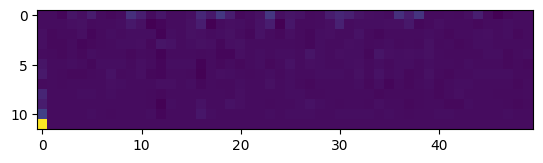

In [ ]:
plt.figure()
plt.imshow(patched_attn_diff.detach().numpy())

In [6]:
from vit_prisma.utils import prisma_utils
from tqdm import tqdm

# Do activation patching
def patch_residual_component(
        corrupted_residual_component,
        hook,
        pos,
        clean_cache
):
    corrupted_residual_component[:, pos, :] = clean_cache[hook.name][:, pos, :]
    return corrupted_residual_component

def normalize_patched_logit_diff(patched_logit_diff):
    # Subtract corrupted logit diff to measure the improvement, divide by the total improvement from clean to corrupted to normalise
    # 0 means zero change, negative means actively made worse, 1 means totally recovered clean performance, >1 means actively *improved* on clean performance
    return (patched_logit_diff - corrupted_logit_diff) / (
        original_average_logit_diff - corrupted_logit_diff)

patched_attn_diff = torch.zeros(
    prisma_model.cfg.n_layers, 50, dtype=torch.float32
)
patched_mlp_diff = torch.zeros(
    prisma_model.cfg.n_layers, 50, dtype=torch.float32
)

image_cuda = crop_out_dog.unsqueeze(0)
for layer in tqdm(range(prisma_model.cfg.n_layers)):
    for position in range(50):
        hook_fn = partial(patch_residual_component, pos=position, clean_cache=cache)

        patched_mlp_logits = prisma_model.run_with_hooks(
            image_cuda,
            fwd_hooks=[(prisma_utils.get_act_name("mlp_out", layer), hook_fn)],
            # return_type="logits",
        )
        patched_mlp_logit_diff = logits_to_ave_logit_diff(
            patched_mlp_logits, answer_tokens
        )


       
        patched_mlp_diff[layer, position] = normalize_patched_logit_diff(
            patched_mlp_logit_diff
        )

        del patched_mlp_logits, patched_mlp_logit_diff


  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [08:01<00:00, 40.09s/it]


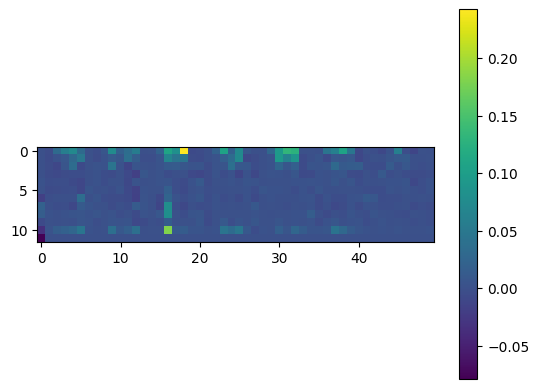

In [10]:
np_mlp_diff = patched_mlp_diff.detach().numpy()
plt.figure()
plt.imshow(patched_mlp_diff.detach().numpy())
plt.colorbar()

# Turn into interactive so you can hover over the patch number



In [13]:
import plotly.express as px
import numpy as np

# Assuming patched_mlp_diff is a 2D numpy array with shape (n_layers, n_patches)
# For demonstration, let's create a dummy 2D array if not already defined
# This should be replaced with: patched_mlp_diff.detach().numpy() if you have the tensor
n_layers = 12  # Example number of layers
n_patches = 50  # Example number of patches

# Create a text label array to display layer and patch numbers
text_labels = np.array([['Layer: {}, Patch: {}'.format(i, j) for j in range(n_patches)] for i in range(n_layers)])

fig = px.imshow(
    np_mlp_diff,
    labels=dict(x="Patch Number", y="Layer Number", color="Difference"),
    x=np.arange(n_patches),
    y=np.arange(n_layers),
    text_auto=False,
    color_continuous_scale='viridis'  # or any other color scale
)

# Update traces to show custom text (layer and patch numbers)
for i in range(len(fig.data)):
    fig.data[i].text = text_labels
    fig.data[i].hovertemplate = 'Layer: %{y}<br>Patch: %{x}<br>Difference: %{z}<extra></extra>'

fig.update_layout(
    title="Normalized Patched MLP Difference per Layer and Patch",
    xaxis_title="Patch Number",
    yaxis_title="Layer Number"
)

fig.update_xaxes(side="top")  # Move the x-axis to the top

# Save the plot as HTML file
file_path = "/home/mila/s/sonia.joseph/prisma-development/html/activation_patching_mlp.html"
fig.write_html(file_path)

file_path

fig.show()


# Patch attn heads individually

In [ ]:
def patch_head_vector(
    corrupted_head_vector,
    hook,
    head_index,
    clean_cache,
):
    corrupted_head_vector[:, :, head_index, :] = clean_cache[hook.name][
        :, :, head_index, :
    ]
    return corrupted_head_vector


patched_head_z_diff = torch.zeros(
    prisma_model.cfg.n_layers, prisma_model.cfg.n_heads, dtype=torch.float32
)
for layer in tqdm(range(prisma_model.cfg.n_layers)):
    for head_index in range(prisma_model.cfg.n_heads):
        hook_fn = partial(patch_head_vector, head_index=head_index, clean_cache=cache)
        patched_logits = prisma_model.run_with_hooks(
            image_cuda,
            fwd_hooks=[(prisma_utils.get_act_name("z", layer, "attn"), hook_fn)],
            # return_type="logits",
        )
        patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens)

        patched_head_z_diff[layer, head_index] = normalize_patched_logit_diff(
            patched_logit_diff
        )

: 